In [1]:
import sys
sys.path.append("..")

import pandas as pd
import ast  # Abstract Syntax Trees - safely parse string list to Python list
from reader import generic_reader
from inflation import read_cpi_by_year, convert_usd

In [2]:
cpi_by_year = read_cpi_by_year("inflation_data/cpiai.csv")

In [3]:
df_movies = generic_reader.read_csv_file_to_data_frame("../movie_data/movies_min_10_votes_first_10000.csv")
df_movies['genre_ids'] = df_movies['genre_ids'].apply(ast.literal_eval) # Turn genre_ids into actual Python list
df_movies['director_person_ids'] = df_movies['director_person_ids'].apply(ast.literal_eval) # Turn director_person_ids into actual Python list
df_movies.info()
df_movies.sort_values(by="budget", ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   adult                   10000 non-null  bool   
 1   backdrop_path           8717 non-null   object 
 2   budget                  10000 non-null  int64  
 3   homepage                2746 non-null   object 
 4   movie_id                10000 non-null  int64  
 5   imdb_id                 9950 non-null   object 
 6   origin_country          10000 non-null  object 
 7   original_language       10000 non-null  object 
 8   original_title          10000 non-null  object 
 9   overview                9992 non-null   object 
 10  popularity              10000 non-null  float64
 11  poster_path             9939 non-null   object 
 12  production_countries    10000 non-null  object 
 13  release_date            10000 non-null  object 
 14  revenue                 10000 non-null 

,adult,backdrop_path,budget,homepage,movie_id,imdb_id,origin_country,original_language,original_title,overview,...,vote_average,vote_count,director_person_ids,genre_ids,production_company_ids,collection_id,cast_person_ids,cast_credit_ids,crew_person_ids,crew_credit_ids
9510,False,/uzIGtyS6bbnJzGsPL93WCF1FWm8.jpg,379000000,https://movies.disney.com/pirates-of-the-carib...,1865,tt1298650,"['US', 'GB']",en,Pirates of the Caribbean: On Stranger Tides,Captain Jack Sparrow crosses paths with a woma...,...,6.561,14502,[17633],"[12, 28, 14]","[2, 130, 20478]",295.0,"[85, 955, 118, 6972, 2449, 237455, 469759, 111...","['52fe431cc3a36847f803af13', '52fe431cc3a36847...","[17633, 1706, 947, 406204, 770, 1705, 1526463,...","['52fe431cc3a36847f803af0f', '52fe431cc3a36847..."
5362,False,/1jHxkVXMI5s3vRiyiZooUy1shB5.jpg,300000000,https://movies.disney.com/pirates-of-the-carib...,285,tt0449088,['US'],en,Pirates of the Caribbean: At World's End,Will Turner and Elizabeth Swann join forces wi...,...,7.262,14944,[1704],"[12, 14, 28]","[130, 19936, 2]",295.0,"[85, 118, 114, 116, 1709, 2440, 378, 1710, 171...","['52fe4232c3a36847f800b50d', '52fe4232c3a36847...","[2445, 1721, 406204, 770, 2215, 553, 2444, 170...","['52fe4232c3a36847f800b561', '52fe4232c3a36847..."
9016,False,/cWczNud8Y8i8ab0Z4bxos4myWYO.jpg,260000000,http://disney.go.com/disneypictures/tangled/,38757,tt0398286,['US'],en,Tangled,"Feisty teenager Rapunzel, who has long and mag...",...,7.600,11944,"[121830, 76595]","[16, 10751, 12]","[6125, 2]",1268789.0,"[16855, 69899, 2517, 2372, 22132, 4175, 18, 12...","['530d35a2925141141e0017ff', '530d35bf92514114...","[121830, 76595, 15813, 56612, 7879, 139474, 13...","['52fe46db9251416c910620ad', '52fe46db9251416c..."
5319,False,/w1oD1MzHjnBJc5snKupIQaSBLIh.jpg,258000000,https://www.sonypictures.com/movies/spiderman3,559,tt0413300,['US'],en,Spider-Man 3,The seemingly invincible Spider-Man goes up ag...,...,6.445,14701,[7623],"[28, 12, 878]","[326, 420, 5]",556.0,"[2219, 205, 17051, 19159, 17052, 18997, 18998,...","['52fe4252c3a36847f80151c7', '52fe4252c3a36847...","[7626, 7630, 7624, 11411, 10850, 10570, 19156,...","['52fe4252c3a36847f8015133', '52fe4252c3a36847..."
8035,False,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,237000000,https://www.avatar.com/movies/avatar,19995,tt0499549,['US'],en,Avatar,"In the 22nd century, a paraplegic Marine is di...",...,7.594,32655,[2710],"[28, 12, 14, 878]","[444, 574, 25, 290]",87096.0,"[65731, 8691, 10205, 32747, 17647, 1771, 59231...","['5602a8a7c3a3685532001c9a', '52fe48009251416c...","[58871, 2710, 1721, 8529, 18265, 6347, 2710, 4...","['52fe48009251416c750aca1d', '52fe48009251416c..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9979,False,/k1MsyDlkIgSvPIOuciIGMX8gCAO.jpg,0,NaN,84520,tt1522846,['US'],en,The Bunny Game,A prostitute looking for her next meal hitches...,...,4.700,160,[910328],"[27, 18]",[164242],NaN,"[930803, 930804, 1077792, 1164799, 1164800, 11...","['52fe48fa9251416c9109e91d', '52fe48fa9251416c...","[910328, 910328, 930803, 3304998, 930803, 9103...","['52fe48fa9251416c9109e943', '52fe48fa9251416c..."
9980,False,/vQfK6smq3XQxPA2r2zgzfQXTN7M.jpg,0,http://www.catechismcataclysm.com/,83330,tt1772371,['US'],en,The Catechism Cataclysm,Father William Smoortser drops his bible into ...,...,4.500,15,[45421],[35],[20848],NaN,"[141433, 79416, 1063282, 1063283, 1063284, 50711]","['52fe48989251416c91091ef5', '52fe48989251416c...","[45421, 45421, 148735, 1103632, 303064, 171851...","['52fe48989251416c91091eeb', '52fe48989251416c..."
9981,False,/pH3xhiDWgH6fkihYkcePLoZ1Faz.jpg,0,http://www.bbc.co.uk/programmes/b0162zbx,76750,tt1981637,"['US', 'GB']",en,Holy Flying Circus,A fantastical re-imagining of the events of 19...,...,6.300,35,[220702],"[10770, 35, 18]","[5645, 64091]",NaN,"[11275, 17123, 281527, 429541, 515127, 27678, ...","['52fe494bc3a368484e1243bb', '52fe494bc3a36848...","[220702, 1220666, 1449192, 1287460, 97055, 242...","['52fe494bc3a368484e1243d9', '5604894092

Drop movies which are documentaries, or Animation Films or Short Films

In [4]:
df_movies = df_movies[df_movies["runtime"] >= 60]
print(len(df_movies))
df_movies = df_movies[~df_movies['genre_ids'].apply(lambda genre_id: 16 in genre_id or 99 in genre_id)]
len(df_movies)

9056


7642

In [5]:
# Drop all movies which does not have excatly one director
df_movies = df_movies[df_movies['director_person_ids'].apply(lambda x: len(x) == 1)]
df_movies['director'] = df_movies['director_person_ids'].apply(lambda x: x[0])

In [6]:
columns_to_keep = ['movie_id', 'original_title', 'release_date', 'budget', 'revenue', 'vote_average', 'vote_count', 'director', 'director_person_ids', 'genre_ids']
df_movies = df_movies[columns_to_keep].copy()
df_movies

,movie_id,original_title,release_date,budget,revenue,vote_average,vote_count,director,director_person_ids,genre_ids
1,300236,Carnage: The Legend of Quiltface,2000-01-01,0,0,2.500,10,103123,[103123],[27]
2,96716,The Bumblebee Flies Anyway,2000-01-01,0,0,6.200,30,126537,[126537],"[18, 10749]"
3,71618,After Sex,2000-01-01,0,0,5.000,27,176312,[176312],"[35, 18, 10749]"
5,56721,The Mummy Theme Park,2000-01-01,0,0,4.000,14,1595512,[1595512],[27]
7,48235,The Complete Works of William Shakespeare (Abr...,2000-01-01,0,0,7.100,10,930753,[930753],[35]
...,...,...,...,...,...,...,...,...,...,...
9995,92398,Cassadaga,2011-10-22,0,1678,5.021,97,111059,[111059],"[27, 53]"
9996,84564,Fred 2: Night of the Living Fred,2011-10-22,0,0,5.200,90,58316,[58316],"[12, 35, 10751, 10770]"
9997,78339,Memory Lane,2011-10-22,300,0,4.500,20,583766,[583766],"[53, 80, 878]"
9998,77068,War of the Dead,2011-10-22,0,0,4.100,72,1053404,[1053404],"[27, 28, 12]"


In [7]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7277 entries, 1 to 9999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   movie_id             7277 non-null   int64  
 1   original_title       7277 non-null   object 
 2   release_date         7277 non-null   object 
 3   budget               7277 non-null   int64  
 4   revenue              7277 non-null   int64  
 5   vote_average         7277 non-null   float64
 6   vote_count           7277 non-null   int64  
 7   director             7277 non-null   int64  
 8   director_person_ids  7277 non-null   object 
 9   genre_ids            7277 non-null   object 
dtypes: float64(1), int64(5), object(4)
memory usage: 625.4+ KB


In [8]:
# Drop movies where budget is zero
df_movies = df_movies[df_movies['budget'] != 0].copy()
# df_movies = df_movies[(df_movies['budget'] != 0) & (df_movies['revenue'] != 0)].copy()
len(df_movies)

3099

In [9]:
# Convert release_date into proper datetime objects
df_movies['release_date'] = pd.to_datetime(df_movies['release_date'])

# Create year column
df_movies['release_year'] = df_movies['release_date'].dt.year
df_movies.sort_values(by="release_year", ascending=False)

,movie_id,original_title,release_date,budget,revenue,vote_average,vote_count,director,director_person_ids,genre_ids,release_year
9990,50837,Martha Marcy May Marlene,2011-10-21,1000000,3500000,6.606,777,527607,[527607],"[18, 53]",2011
9920,10316,The Ides of March,2011-10-07,12500000,76338111,6.676,2583,1461,[1461],[18],2011
9997,78339,Memory Lane,2011-10-22,300,0,4.500,20,583766,[583766],"[53, 80, 878]",2011
9993,101501,The Afflicted,2011-10-22,180000,175742,4.453,32,1027827,[1027827],"[27, 53]",2011
9989,61891,Anonymous,2011-10-21,30000000,15395087,6.410,746,6046,[6046],"[18, 36, 53]",2011
...,...,...,...,...,...,...,...,...,...,...,...
126,2085,Romeo Must Die,2000-03-22,25000000,91036760,6.275,1253,10765,[10765],"[28, 80, 53]",2000
130,37722,Waking the Dead,2000-03-24,8500000,327418,6.100,98,33054,[33054],"[9648, 18, 10749]",2000
132,13539,Here on Earth,2000-03-24,15000000,10873148,5.800,186,1219210,[1219210],"[10749, 18]",2000
139,51333,Love's Labour's Lost,2000-03-31,13000000,300000,5.500,72,11181,[11181],"[35, 10402, 10749]",2000


In [10]:
# Convert budget to 2023 USD
df_movies['budget_2023_usd'] = df_movies.apply(
    lambda row: convert_usd(
        original_amount=row['budget'],
        original_year=row['release_year'],
        new_year=2023,
        cpi_by_year=cpi_by_year
    ),
    axis=1
)

# Convert revenue to 2023 USD
df_movies['revenue_2023_usd'] = df_movies.apply(
    lambda row: convert_usd(
        original_amount=row['revenue'],
        original_year=row['release_year'],
        new_year=2023,
        cpi_by_year=cpi_by_year
    ),
    axis=1
)

In [11]:
df_movies
df_movies.sort_values(by="budget_2023_usd", ascending=False)

,movie_id,original_title,release_date,budget,revenue,vote_average,vote_count,director,director_person_ids,genre_ids,release_year,budget_2023_usd,revenue_2023_usd
9510,1865,Pirates of the Caribbean: On Stranger Tides,2011-05-15,379000000,1046721266,6.561,14502,17633,[17633],"[12, 28, 14]",2011,513391695,1417883919
5362,285,Pirates of the Caribbean: At World's End,2007-05-19,300000000,961691209,7.262,14944,1704,[1704],"[12, 14, 28]",2007,440867221,1413260435
5319,559,Spider-Man 3,2007-05-01,258000000,894983373,6.445,14701,7623,[7623],"[28, 12, 878]",2007,379145810,1315229441
4507,1452,Superman Returns,2006-06-28,223000000,391081192,5.791,4381,9032,[9032],"[878, 28, 12]",2006,337059831,591111033
8035,19995,Avatar,2009-12-15,237000000,2923706026,7.594,32655,2710,[2710],"[28, 12, 14, 878]",2009,336605225,4152467198
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8529,270650,Oy Vey! My Son Is Gay!,2010-06-18,2,6000007,5.000,29,1359976,[1359976],"[35, 10749]",2010,3,8384157
4851,140172,Cool Air,2006-11-03,1,0,4.800,13,63937,[63937],[27],2006,2,0
6559,20034,Hush,2008-08-13,1,0,5.600,155,86482,[86482],"[53, 27, 28]",2008,1,0
7602,49970,Junkyard Dog,2009-08-09,1,0,4.100,11,134878,[134878],"[27, 53]",2009,1,0


Calculate profit and ROI

In [12]:
df_movies['profit_2023_usd'] = df_movies['revenue_2023_usd'] - df_movies['budget_2023_usd']
df_movies['roi'] = ( df_movies['profit_2023_usd'] / df_movies['budget_2023_usd'] )*100
df_movies.sort_values(by="profit_2023_usd", ascending=False)

,movie_id,original_title,release_date,budget,revenue,vote_average,vote_count,director,director_person_ids,genre_ids,release_year,budget_2023_usd,revenue_2023_usd,profit_2023_usd,roi
8035,19995,Avatar,2009-12-15,237000000,2923706026,7.594,32655,2710,[2710],"[28, 12, 14, 878]",2009,336605225,4152467198,3815861973,1133.631236
2542,122,The Lord of the Rings: The Return of the King,2003-12-17,94000000,1118888979,8.489,25492,108,[108],"[12, 14, 28]",2003,155698023,1853285129,1697587106,1090.307425
1863,121,The Lord of the Rings: The Two Towers,2002-12-18,79000000,926287400,8.409,22948,108,[108],"[12, 14, 28]",2002,133823072,1569096525,1435273453,1072.515697
1199,120,The Lord of the Rings: The Fellowship of the Ring,2001-12-18,93000000,871368364,8.424,26418,108,[108],"[12, 14, 28]",2001,160037164,1499476582,1339439418,836.955232
4516,58,Pirates of the Caribbean: Dead Man's Chest,2006-07-06,200000000,1066179747,7.371,16613,1704,[1704],"[12, 14, 28]",2006,302295812,1611508364,1309212552,433.089874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2257,8046,Gigli,2003-08-01,75600000,7266209,4.066,476,769,[769],"[35, 80, 18, 10749]",2003,125220963,12035472,-113185491,-90.388612
510,10783,Lucky Numbers,2000-10-27,65000000,0,5.200,189,9248,[9248],"[35, 80]",2000,115015116,0,-115015116,-100.000000
2744,10733,The Alamo,2004-04-07,107000000,25819961,5.761,345,54040,[54040],"[36, 10752, 18]",2004,172609562,41652076,-130957486,-75.869195
795,24113,Town & Country,2001-04-27,90000000,10372291,4.500,75,36804,[36804],"[35, 10749]",2001,154874675,17848947,-137025728,-88.475232


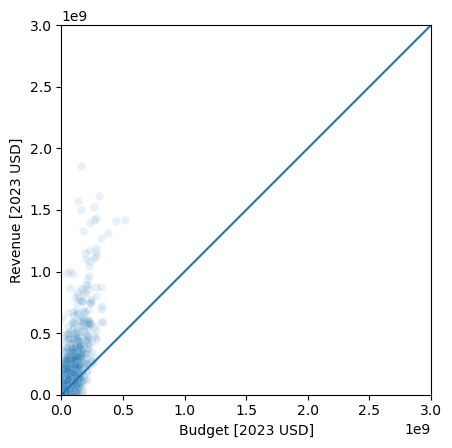

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(x=df_movies['budget_2023_usd'], y=df_movies['revenue_2023_usd'], alpha=0.1)
plt.xlim(0, 3e9)
plt.ylim(0, 3e9)
plt.gca().set_aspect('equal', adjustable='box')
plt.plot([0, 3e9], [0, 3e9])
plt.xlabel("Budget [2023 USD]")
plt.ylabel("Revenue [2023 USD]");

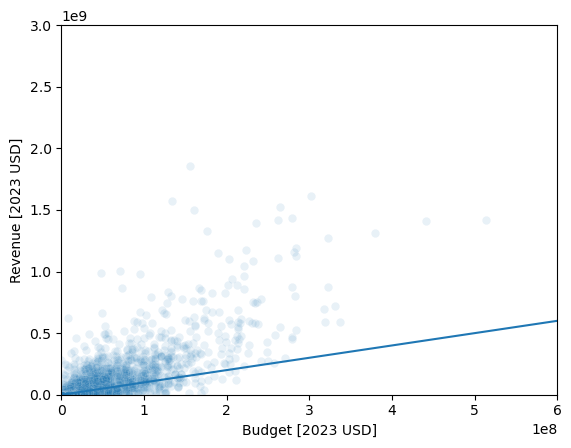

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(x=df_movies['budget_2023_usd'], y=df_movies['revenue_2023_usd'], alpha=0.1)
plt.xlim(0, 0.6e9)
plt.ylim(0, 3e9)
# plt.gca().set_aspect('equal', adjustable='box')
plt.plot([0, 3e9], [0, 3e9])
plt.xlabel("Budget [2023 USD]")
plt.ylabel("Revenue [2023 USD]");

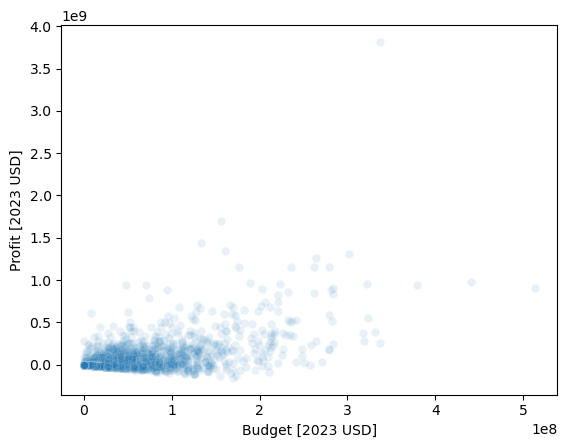

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(x=df_movies['budget_2023_usd'], y=df_movies['profit_2023_usd'], alpha=0.1)
# plt.xlim(0, 0.6e9)
# plt.ylim(0, 3e9)
# plt.gca().set_aspect('equal', adjustable='box')
# plt.plot([0, 3e9], [0, 3e9])
plt.xlabel("Budget [2023 USD]")
plt.ylabel("Profit [2023 USD]");

<Axes: xlabel='budget_2023_usd', ylabel='vote_average'>

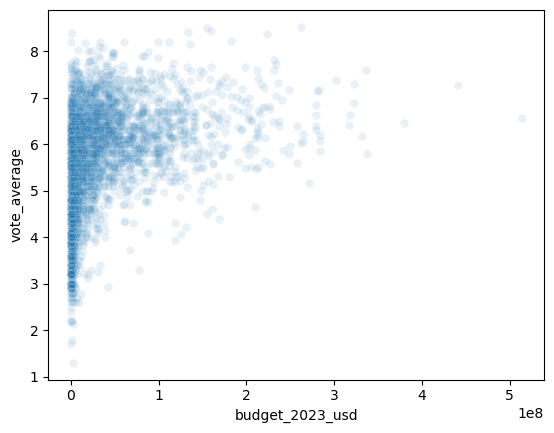

In [16]:
sns.scatterplot(x=df_movies['budget_2023_usd'], y=df_movies['vote_average'], alpha=0.1)

<Axes: xlabel='profit_2023_usd', ylabel='vote_average'>

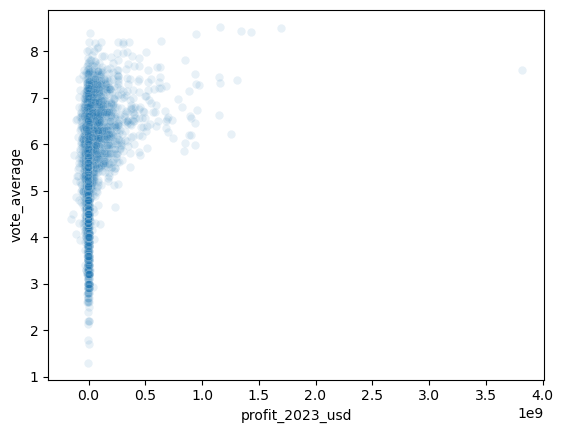

In [17]:
sns.scatterplot(x=df_movies['profit_2023_usd'], y=df_movies['vote_average'], alpha=0.1)

(-100.0, 2000.0)

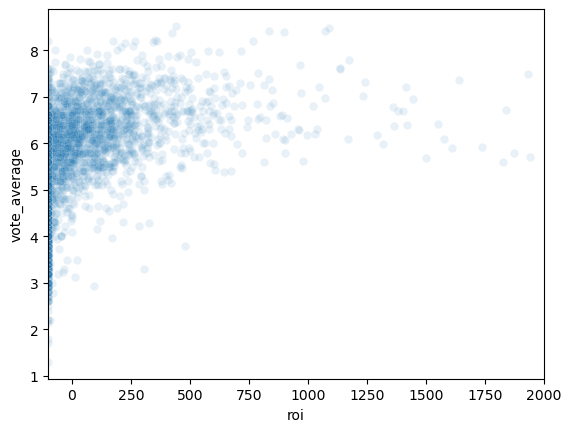

In [18]:
sns.scatterplot(x=df_movies['roi'], y=df_movies['vote_average'], alpha=0.1)
plt.xlim(-100, 2000)

In [19]:
# # Define a function for rating_category
# def get_rating_category(vote_average):
#     if vote_average >= 7:
#         return "good";
#     if vote_average >= 5:
#         return "ok";
#     else:
#         return "bad";
    
# Define a function for rating_category
def get_rating_category(vote_average):
    if vote_average >= 6:
        return "good";
    else:
        return "bad";

# Apply the function to df_movies 
df_movies['rating_category'] = df_movies['vote_average'].apply(get_rating_category)
df_movies.sort_values(by="vote_average", ascending=False)

,movie_id,original_title,release_date,budget,revenue,vote_average,vote_count,director,director_person_ids,genre_ids,release_year,budget_2023_usd,revenue_2023_usd,profit_2023_usd,roi,rating_category
6493,155,The Dark Knight,2008-07-16,185000000,1004558444,8.523,34471,525,[525],"[18, 28, 80, 53]",2008,261816713,1421676703,1159859990,443.004565,good
2542,122,The Lord of the Rings: The Return of the King,2003-12-17,94000000,1118888979,8.489,25492,108,[108],"[12, 14, 28]",2003,155698023,1853285129,1697587106,1090.307425,good
1199,120,The Lord of the Rings: The Fellowship of the Ring,2001-12-18,93000000,871368364,8.424,26418,108,[108],"[12, 14, 28]",2001,160037164,1499476582,1339439418,836.955232,good
1863,121,The Lord of the Rings: The Two Towers,2002-12-18,79000000,926287400,8.409,22948,108,[108],"[12, 14, 28]",2002,133823072,1569096525,1435273453,1072.515697,good
4893,18527,Madonna: The Confessions Tour,2006-11-22,1000000,10000000,8.400,51,71329,[71329],[10402],2006,1511479,15114791,13603312,900.000066,good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4556,29046,Scorpius Gigantus,2006-07-25,210000,0,2.200,11,102653,[102653],"[27, 878]",2006,317411,0,-317411,-100.000000,bad
3712,267913,Vampire Assassin,2005-08-09,1500000,0,2.136,11,1801790,[1801790],"[27, 28]",2005,2340358,0,-2340358,-100.000000,bad
9188,118332,Total Retribution,2011-02-02,1500000,0,1.800,13,98360,[98360],"[27, 878, 53]",2011,2031893,0,-2031893,-100.000000,bad
213,203023,Witchcraft XI: Sisters in Blood,2000-05-09,40,0,1.700,11,98712,[98712],[27],2000,71,0,-71,-100.000000,bad


In [20]:
# # Drop all movies with rating 'bad'
# df_movies = df_movies[df_movies['rating_category'] != 'bad'].copy()

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Encode target variable
le_rating = LabelEncoder()
df_movies['rating_encoded'] = le_rating.fit_transform(df_movies['rating_category'])
df_movies

# Independet variables (X) and dependent variable (y)
X = df_movies[['budget_2023_usd', 'director']]
y = df_movies['rating_encoded']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=321)

# Train model
model = RandomForestClassifier(class_weight='balanced')
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred, target_names=le_rating.classes_))

              precision    recall  f1-score   support

         bad       0.65      0.70      0.67       385
        good       0.68      0.63      0.66       390

    accuracy                           0.66       775
   macro avg       0.67      0.66      0.66       775
weighted avg       0.67      0.66      0.66       775

